In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/CS4246/Project/')

In [2]:
from game_env_trunc import GameEnv
from utils import live_plot

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import tqdm

In [3]:
# !pip install --upgrade gym

In [4]:
assert gym.__version__ >= "0.26.2", "This notebook requires at least Gym 0.26.2"

## Maze game

In [5]:
def create_env():
    env = GameEnv((20,20), (19,20), (1,1), 300)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    return env

NUM_ENVS = 16
envs = gym.vector.SyncVectorEnv([lambda: create_env() for _ in range(NUM_ENVS)])

## Agent

In [6]:
def layer_init(layer, bias_const=0.0):
    """Initialize the weights and biases of a layer.

    Args:
        layer (nn.Module): The layer to initialize.
        std (float): Standard deviation for orthogonal initialization.
        bias_const (float): Constant value for bias initialization.

    Returns:
        nn.Module: The initialized layer.
    """
    torch.nn.init.xavier_uniform_(layer.weight)  # Orthogonal initialization
    torch.nn.init.constant_(layer.bias, bias_const)  # Constant bias
    return layer

In [7]:
class Agent(nn.Module):
    def __init__(self, actor_input_size, critic_input_size, actor_output_size, critic_output_size):
        super(Agent, self).__init__()
        hidden_size1, hidden_size2, hidden_size3 = 64, 128, 64
        self.actor = nn.Sequential(
            layer_init(nn.Linear(actor_input_size, hidden_size1)),
            nn.LeakyReLU(),
            layer_init(nn.Linear(hidden_size1, hidden_size2)),
            nn.LeakyReLU(),
            layer_init(nn.Linear(hidden_size2, hidden_size3)),
            nn.LeakyReLU(),
            layer_init(nn.Linear(hidden_size3, actor_output_size))
        )
        self.critic = nn.Sequential(
            layer_init(nn.Linear(critic_input_size, hidden_size1)),
            nn.LeakyReLU(),
            layer_init(nn.Linear(hidden_size1, hidden_size2)),
            nn.LeakyReLU(),
            layer_init(nn.Linear(hidden_size2, hidden_size3)),
            nn.LeakyReLU(),
            layer_init(nn.Linear(hidden_size3, critic_output_size))
        )

    def get_value(self, state):
        return self.critic(state)

    def get_action_probs(self, state):
        return torch.distributions.categorical.Categorical(logits = self.actor(state))

    def get_action(self, probs):
        return probs.sample()

    def get_action_logprob(self, probs, action):
        return probs.log_prob(action)

    def get_entropy(self, probs):
        return probs.entropy()

    def get_action_logprob_entropy(self, state):
        probs = self.get_action_probs(state)
        action = self.get_action(probs)
        logprob = self.get_action_logprob(probs, action)
        entropy = self.get_entropy(probs)
        return action, logprob, entropy



In [8]:
LEARNING_RATE = 1e-3
weight_decay = 1e-4

ROLLOUT_STEPS = 128
NUM_MINI_BATCHES = NUM_EPOCHS = 4
TOTAL_STEPS = 3200000

GAMMA = 0.99
GAE_LAMBDA = 0.95

CLIP_COEF = 0.2
VALUE_LOSS_COEF = 0.5
ENTROPY_COEF = 0.1

BATCH_SIZE = ROLLOUT_STEPS * NUM_ENVS
MINI_BATCH_SIZE = BATCH_SIZE // NUM_MINI_BATCHES
NUM_ITERATIONS = TOTAL_STEPS // BATCH_SIZE

## Loss Functions

In [9]:
def get_deltas(rewards, values, next_values, next_nonterminal, gamma):
    deltas = rewards + gamma*next_values*next_nonterminal - values
    return deltas

def get_ratio(logprob, logprob_old):
    logratio = logprob-logprob_old
    ratio = torch.exp(logratio)
    return ratio

def get_policy_objective(advantages, ratio, clip_coeff=CLIP_COEF):
    policy_objective1 = ratio*advantages
    policy_objective2 = torch.clamp(ratio, min=1-clip_coeff, max=1+clip_coeff)*advantages
    policy_objective = torch.mean(torch.minimum(policy_objective1, policy_objective2))
    return policy_objective

def get_value_loss(values, values_old, returns, clip_coeff=CLIP_COEF):
    value_loss_unclipped = 0.5*(values - returns)**2

    value_loss_clipped = 0.5*(torch.clamp(values, min=values_old-clip_coeff, max=values_old+clip_coeff) - returns)**2

    value_loss = torch.mean(torch.maximum(value_loss_unclipped, value_loss_clipped))
    return value_loss

def get_entropy_objective(entropy):
    return entropy.mean()

def get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=ENTROPY_COEF):
    total_loss = -policy_objective + value_loss_coeff*value_loss - entropy_coeff*entropy_objective
    return total_loss

In [10]:
# def get_min_reward(state):


## Training

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = Agent(404, 404, 4, 1).to(device)

In [12]:
states = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_action_space.shape).to(device)
rewards = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
dones = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

logprobs = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
values = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)

In [13]:
min_reward = -38
max_reward = 1000

In [14]:
# trunc = 0
# goals = 0
# episodes = 0
# episode_length = []

In [15]:
# trunc_flag = False
# trunc_step = 5

# trunc_history = []

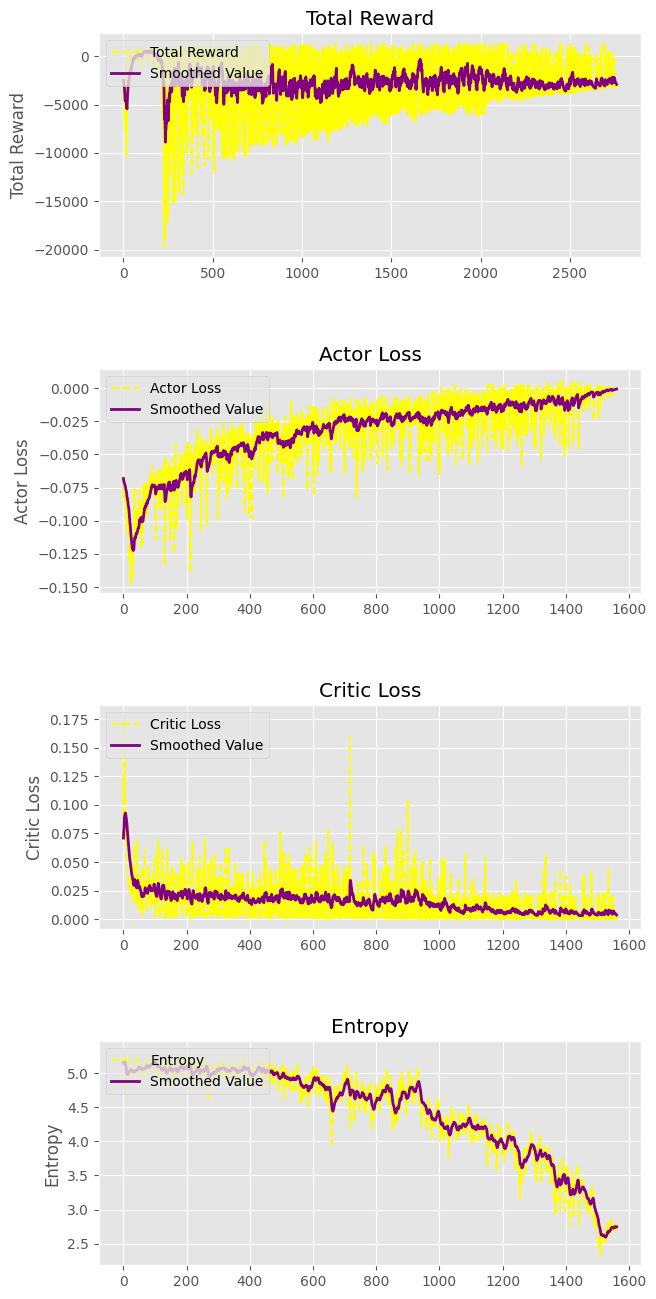

100%|█████████████████████████████████████████████████████| 1562/1562 [1:01:43<00:00,  2.37s/it, Total Rewards=-3188.0]


In [16]:
# Enable inline plotting
%matplotlib inline

# Initialize global step counter and reset the environment
global_step = 0
initial_state, _ = envs.reset()
# print(initial_state[0,])
state = torch.Tensor(initial_state).to(device)
done = torch.zeros(NUM_ENVS).to(device)

# Set up progress tracking
progress_bar = tqdm.tqdm(range(1, NUM_ITERATIONS + 1), postfix={'Total Rewards': 0})
actor_loss_history = []
critic_loss_history = []
entropy_objective_history = []

reward_history = []
episode_history = []

# Initialize the optimizer for the agent's parameters
optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE, eps=1e-5, weight_decay = weight_decay)

for iteration in progress_bar:
    # Adjust the learning rate using a linear decay
    fraction_completed = 1.0 - (iteration - 1.0) / NUM_ITERATIONS
    current_learning_rate = fraction_completed * LEARNING_RATE
    current_entropy_coef =  ENTROPY_COEF
    optimizer.param_groups[0]["lr"] = current_learning_rate

    # Perform rollout to gather experience
    for step in range(0, ROLLOUT_STEPS):
        global_step += NUM_ENVS
        states[step] = state
        dones[step] = done


        with torch.no_grad():
            # Get action, log probability, and entropy from the agent
            action, log_probability, _ = agent.get_action_logprob_entropy(state)
            value = agent.get_value(state)
            values[step] = value.flatten()



        actions[step] = action
        logprobs[step] = log_probability

        # Execute action in the environment
        next_state, reward, done, truncated, info = envs.step(action.cpu().numpy())
        normalized_reward = (reward - min_reward) / (max_reward - min_reward)  # Normalize the reward
        rewards[step] = torch.tensor(normalized_reward).to(device).view(-1)
        state = torch.Tensor(next_state).to(device)
        # print(state)
        done = torch.Tensor(done).to(device)
        truncated = torch.Tensor(truncated).to(device)
#         if trunc_flag:
#             trunc_history.append(f"Step: {step}, Position: {state[:, -4:-2]}, Reward: {reward}, Goal: {state[:, -2:]}, Truncated: {truncated}")
#             trunc_step -= 1
#             if trunc_step == 0:
#                 trunc_flag = False
#                 trunc_step = 5


#         if any(truncated):
#             trunc += 1
#             trunc_flag = True
#             trunc_history.append(f"Step: {step}, Position: {state[:, -4:-2]}, Reward: {reward}, Goal: {state[:, -2:]}, Truncated: {truncated}")
#         if any(done):
#             goals += 1
            # trunc.append(f"Step: {step}, Position: {state[:, -4:-2]}, Reward: {reward}, Goal: {state[:, -2:]}, Truncated: {truncated}")
        # print(state[0, -47:-44])
        # print(state[0, -27:-24])
        # print(state[0, -7:-4])
        # print(torch.flip(state[0, :-4].reshape((20,20))[-3:,-3:].T, dims=(0,)))
        # if done[0].item():
        #   print("DONE")
        #   break

        if "final_info" in info:
#             episodes += 1
            for episode_info in info["final_info"]:
                if episode_info and "episode" in episode_info:
                    episodic_reward = episode_info['episode']['r']
                    reward_history.append(episodic_reward)
                    episode_history.append(global_step)
#                     episode_length.append(episode_info['episode']['l'])
                    progress_bar.set_postfix({'Total Rewards': episodic_reward})

    # if done[0].item():
    #   break

    # Calculate advantages and returns
    with torch.no_grad():
        next_value = agent.get_value(state).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)

        last_gae_lambda = 0
        for t in reversed(range(ROLLOUT_STEPS)):
            if t == ROLLOUT_STEPS - 1:
                next_non_terminal = 1.0 - done
                next_value = next_value
            else:
                next_non_terminal = 1.0 - dones[t + 1]
                next_value = values[t + 1]

            # Compute delta using the utility function
            delta = get_deltas(rewards[t], values[t], next_value, next_non_terminal, gamma=GAMMA)

            advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lambda
        returns = advantages + values

    # Flatten the batch data for processing
    batch_states = states.reshape((-1,) + envs.single_observation_space.shape)
    batch_logprobs = logprobs.reshape(-1)
    batch_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    batch_advantages = advantages.reshape(-1)
    batch_returns = returns.reshape(-1)
    batch_values = values.reshape(-1)

    # Shuffle the batch data to break correlation between samples
    batch_indices = np.arange(BATCH_SIZE)
    total_actor_loss = 0
    total_critic_loss = 0
    total_entropy_objective = 0

    for epoch in range(NUM_EPOCHS):
        np.random.shuffle(batch_indices)
        for start in range(0, BATCH_SIZE, MINI_BATCH_SIZE):
            # Get the indices for the mini-batch
            end = start + MINI_BATCH_SIZE
            mini_batch_indices = batch_indices[start:end]

            mini_batch_advantages = batch_advantages[mini_batch_indices]
            # Normalize advantages to stabilize training
            mini_batch_advantages = (mini_batch_advantages - mini_batch_advantages.mean()) / (mini_batch_advantages.std() + 1e-8)

            # Compute new probabilities and values for the mini-batch
            new_probabilities = agent.get_action_probs(batch_states[mini_batch_indices])
            new_log_probability = agent.get_action_logprob(new_probabilities, batch_actions.long()[mini_batch_indices])
            entropy = agent.get_entropy(new_probabilities)
            new_value = agent.get_value(batch_states[mini_batch_indices])

            # Calculate the policy loss
            ratio = get_ratio(new_log_probability, batch_logprobs[mini_batch_indices])
            policy_objective = get_policy_objective(mini_batch_advantages, ratio, clip_coeff=CLIP_COEF)
            policy_loss = -policy_objective

            # Calculate the value loss
            value_loss = get_value_loss(new_value.view(-1), batch_values[mini_batch_indices], batch_returns[mini_batch_indices], clip_coeff=CLIP_COEF)

            # Calculate the entropy loss
            entropy_objective = get_entropy_objective(entropy)

            # Combine losses to get the total loss
            total_loss = get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=current_entropy_coef)

            optimizer.zero_grad()
            total_loss.backward()
            # Clip the gradient to stabilize training
            nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
            optimizer.step()

            # loss debugging
            # print("Policy Objective:", policy_objective.item())
            # print("Value Loss:", value_loss.item())
            # print("Entropy Objective:", entropy_objective.item())

            total_actor_loss += policy_loss.item()
            total_critic_loss += value_loss.item()
            total_entropy_objective += entropy_objective.item()

    # print("Total Critic Loss:", total_critic_loss / NUM_EPOCHS)

    actor_loss_history.append(total_actor_loss / NUM_EPOCHS)
    critic_loss_history.append(total_critic_loss / NUM_EPOCHS)
    entropy_objective_history.append(total_entropy_objective / NUM_EPOCHS)

    # Prepare data for live plotting
    data_to_plot = {
        'Total Reward': reward_history,
        'Actor Loss': actor_loss_history,
        'Critic Loss': critic_loss_history,
        'Entropy': entropy_objective_history
    }
    live_plot(data_to_plot)

# Close the environment after training
envs.close()

In [17]:
# torch.save(agent.state_dict(), "model_trunc.pth")

In [18]:
# print(episode_length)
# print(np.mean(episode_length))
# print(np.median(episode_length))
# print(np.max(episode_length))
# print(np.min(episode_length))


In [19]:
# print(trunc, goals, episodes)

In [20]:
# reward_history

In [21]:
# for i in range(len(trunc_history)):
#     print(trunc_history[i])

In [22]:
"""
min_reward = -10
max_reward = 1000
optimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE, eps=1e-5)

reward_history = []
actor_losses_history = []
critic_losses_history = []
entropy_objectives_history = []


for iteration in range(1, NUM_ITERATIONS + 1):
    fraction_completed = iteration / NUM_ITERATIONS
    current_learning_rate = fraction_completed * LEARNING_RATE
    optimizer.param_groups[0]["lr"] = current_learning_rate

    # initialize storage to store experience gained
    states = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_observation_space.shape).to(device)
    rewards = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
    dones = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
    logprobs = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
    values = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)
    actions = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_action_space.shape).to(device)

    # gain experience to train the model
    for step in range(0, ROLLOUT_STEPS):
        # update information
        states[step] = state
        rewards[step] = reward
        dones[step] = done

        # get action, actor, and critic
        with torch.no_grad():
            action, log_probability, entropy = agent.get_action_logprob_entropy(state)
            actions[step] = action
            logprobs[step] = log_probability

            value = agent.get_value(state)
            values[step] = value.flatten()

        # execute action in the environment
        next_state, reward, done, _, _ = envs.step(action.cpu().numpy())

        # calculate reward and update state for next iter
        normalized_reward = (reward - min_reward) / (max_reward - min_reward)
        rewards[step] = torch.tensor(normalized_reward).to(device)
        state = torch.Tensor(next_state).to(device)
        done = torch.Tensor(done).to(device)

        calculated = set()
        for i in range(done.size):
            if done[i] and i not in calculated:
                reward_history.append(torch.sum(rewards, dim=0)[i])
                calculated.add(i)

    # calculate advantages and returns
    with torch.no_grad():
        next_value = agent.get_value(state).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)

        last_gae_lambda = 0
        for t in reversed(range(ROLLOUT_STEPS)):
            if t == ROLLOUT_STEPS - 1:
                next_non_terminal = 1.0 - done
                next_value = next_value
            else:
                next_non_terminal = 1.0 - dones[t + 1]
                next_value = values[t + 1]

            # Compute delta using the utility function
            delta = get_deltas(rewards[t], values[t], next_value, next_non_terminal, gamma=GAMMA)

            advantages[t] = last_gae_lambda = delta + GAMMA * GAE_LAMBDA * next_non_terminal * last_gae_lambda
        returns = advantages + values

    # flatten data collected from ecperience to update model
    batch_states = states.reshape((-1,) + envs.single_observation_space.shape)
    batch_logprobs = logprobs.reshape(-1)
    batch_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    batch_advantages = advantages.reshape(-1)
    batch_dones = dones.reshape(-1)
    batch_values = values.reshape(-1)

    N = batch_states.shape[0]

    for epoch in range(NUM_EPOCHS):
        perm = np.random.permutation(N)

        for mini_batch in range(N // BATCH_SIZE):
            start = mini_batch*BATCH_SIZE
            end = (mini_batch+1)*BATCH_SIZE

            # normalize advantages
            mini_batch_advantages = batch_advantages[perm[start:end]]
            mini_batch_advantages = (mini_batch_advantages - mini_batch_advantages.mean()) / (mini_batch_advantages.std() + 1e-8)

            # compute prob, logprob, and entropy for mini batch
            new_probabilities = agent.get_probs(batch_states[mini_batch_indices])
            new_log_probability = agent.get_action_logprob(new_probabilities, batch_actions.long()[mini_batch_indices])
            entropy = agent.get_entropy(new_probabilities)
            new_value = agent.get_value(batch_states[mini_batch_indices])

            # calculate the policy loss
            ratio = get_ratio(new_log_probability, batch_logprobs[mini_batch_indices])
            policy_objective = get_policy_objective(mini_batch_advantages, ratio, clip_coeff=CLIP_COEF)
            policy_loss = -policy_objective

            # calculate the value loss
            value_loss = get_value_loss(new_value.view(-1), batch_values[mini_batch_indices], batch_returns[mini_batch_indices], clip_coeff=CLIP_COEF)

            # calculate the entropy loss
            entropy_objective = get_entropy_objective(entropy)

            # calculate total loss
            total_loss = get_total_loss(policy_objective, value_loss, entropy_objective, value_loss_coeff=VALUE_LOSS_COEF, entropy_coeff=ENTROPY_COEF)

            optimizer.zero_grad()
            total_loss.backward()
            # Clip the gradient to stabilize training
            nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
            optimizer.step()

            total_actor_loss += policy_loss.item()
            total_critic_loss += value_loss.item()
            total_entropy_objective += entropy_objective.item()

    actor_losses_history.append(total_actor_loss // NUM_EPOCHS)
    critic_losses_history.append(total_critic_loss // NUM_EPOCHS)
    entropy_objectives_history.append(total_entropy_objective // NUM_EPOCHS)

    if iteration+1 % 10:
        print("reward: ", reward_history[-1], "actor loss: ", actor_losses_history[-1], "critic loss: ", total_critic_loss, "entropy: ", total_entropy_objective, end="\r")

"""

'\nmin_reward = -10\nmax_reward = 1000\noptimizer = optim.Adam(agent.parameters(), lr=LEARNING_RATE, eps=1e-5)\n\nreward_history = []\nactor_losses_history = []\ncritic_losses_history = []\nentropy_objectives_history = []\n\n\nfor iteration in range(1, NUM_ITERATIONS + 1):\n    fraction_completed = iteration / NUM_ITERATIONS\n    current_learning_rate = fraction_completed * LEARNING_RATE\n    optimizer.param_groups[0]["lr"] = current_learning_rate\n\n    # initialize storage to store experience gained\n    states = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_observation_space.shape).to(device)\n    rewards = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)\n    dones = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)\n    logprobs = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)\n    values = torch.zeros((ROLLOUT_STEPS, NUM_ENVS)).to(device)\n    actions = torch.zeros((ROLLOUT_STEPS, NUM_ENVS) + envs.single_action_space.shape).to(device)\n\n    # gain experience to train t